In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt
from onepower import Spectra

from params_benchmark import kwargs_pk

from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 16})

/Users/ferreirat/.pyenv/versions/cosmosis/lib/python3.11/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [ ]:
# Common parameters
# -----------------------

omega_m = 0.3       # Total matter density (cold dark matter + baryonic matter)
omega_c = 0.25      # Cold dark matter density
omega_b = 0.05      # Baryonic matter density

h0 = 0.7            # Dimensionless Hubble parameter
ns = 0.9            # Spectral index

k_lower = -4 # k-range [h/Mpc]
k_upper = 1  # k-range [h/Mpc]

# CAMB settings
# -----------------------
# Cosmology
camb_cosmo = {
    'omch2': omega_c * h0 ** 2,  # Omega_c * h^2 (CDM density)
    'ombh2': omega_b * h0 ** 2,  # Omega_b * h^2 (baryon density)
    'H0': h0 * 100,              # Hubble constant in km/s/Mpc
    'ns': ns,                    # Spectral index
    'As': 2.1e-9,                # Scalar amplitude
}
camb_de = {
    'w': -1.0,
    'wa': 0.0,
}

# Neutrino settings
no_neutrinos = {
    'num_massive_neutrinos': 0,  # Effective number of massive neutrinos
    'mnu': 0,                    # Sum of neutrino masses in eV (set to 0)
}

# Redshift and k-range settings
z = 0
kmin = 10 ** k_lower
kmax = 10 ** k_upper
nk = 5000

# OnePower settings
# -----------------------------
# Cosmology
params_cosmo = {
    'omega_c': omega_c,    # Cold dark matter density
    'omega_b': omega_b,    # Baryonic matter density
    'h0': h0,              # Dimensionless Hubble parameter
    'n_s': ns,             # Spectral index (note different key name than CAMB)
#    'sigma_8': 0.8,        # RMS linear density fluctuation in 8 Mpc/h spheres
#    'm_nu': 0.0,           # Neutrino mass
    'tcmb': 2.7255,
    'w0': -1.0,
    'wa': 0.0,
}

# Power Spectrum
params_pk = {
    'k_vec': np.logspace(k_lower, k_upper, nk),
    'lnk_min': float(np.log(10**(-8))),
    'lnk_max': float(np.log(10**(8))),
    'dlnk': 0.001,
    'z_vec': np.array([0.0]),
    'growth_model': 'CambGrowth',
}

## Transfer Function

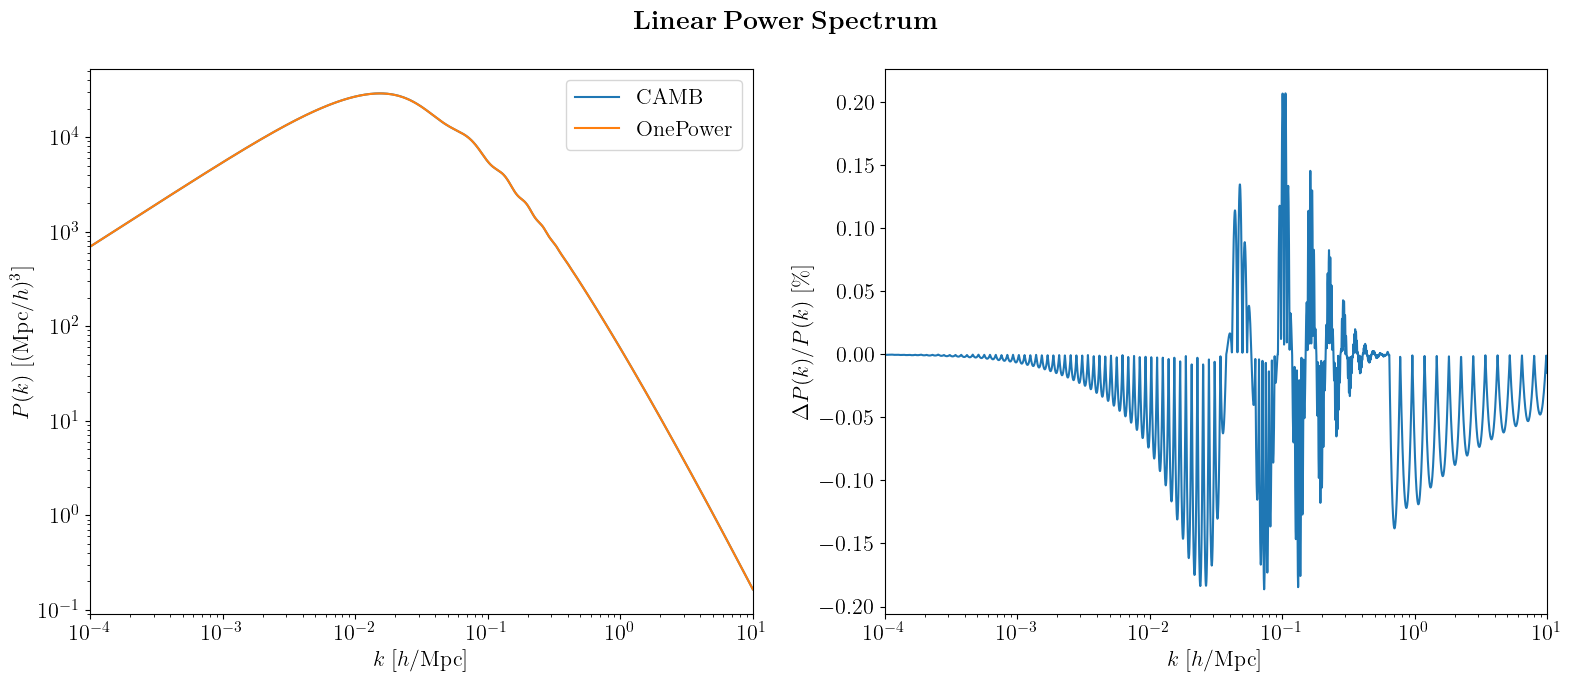

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# CAMB Power Spectrum

cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin = powerspec

ax1.plot(kh, camb_pk_lin[0],
         label=r'$\mathrm{CAMB}$')

# =================================================================================
# Transfer Function from CAMB (for Onepower)

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot')
transfer_k = results.get_matter_transfer_data().transfer_z('k/h')

# =================================================================================
# Onepower Power Spectrum

model_CAMB = Spectra(
        m_nu=0.0,
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs_pk)

ax1.plot(model_CAMB.k_vec, model_CAMB.power_spectrum_lin.pk_tot[0,0,:],
         label=r'$\mathrm{OnePower}$')

# =================================================================================
# Relative Difference

diff_CAMB = (model_CAMB.power_spectrum_lin.pk_tot[0,0,:]
             - camb_pk_lin[0])/camb_pk_lin[0]

ax2.plot(kh, diff_CAMB * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        yscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$P(k) \ [(\mathrm{Mpc}/h)^3]$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)\ [\%]$')

fig.suptitle(r'$\mathbf{Linear\ Power\ Spectrum}$')

plt.tight_layout()
plt.savefig('Pk_linear_bf.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

#
## Transfer function and neutrinos

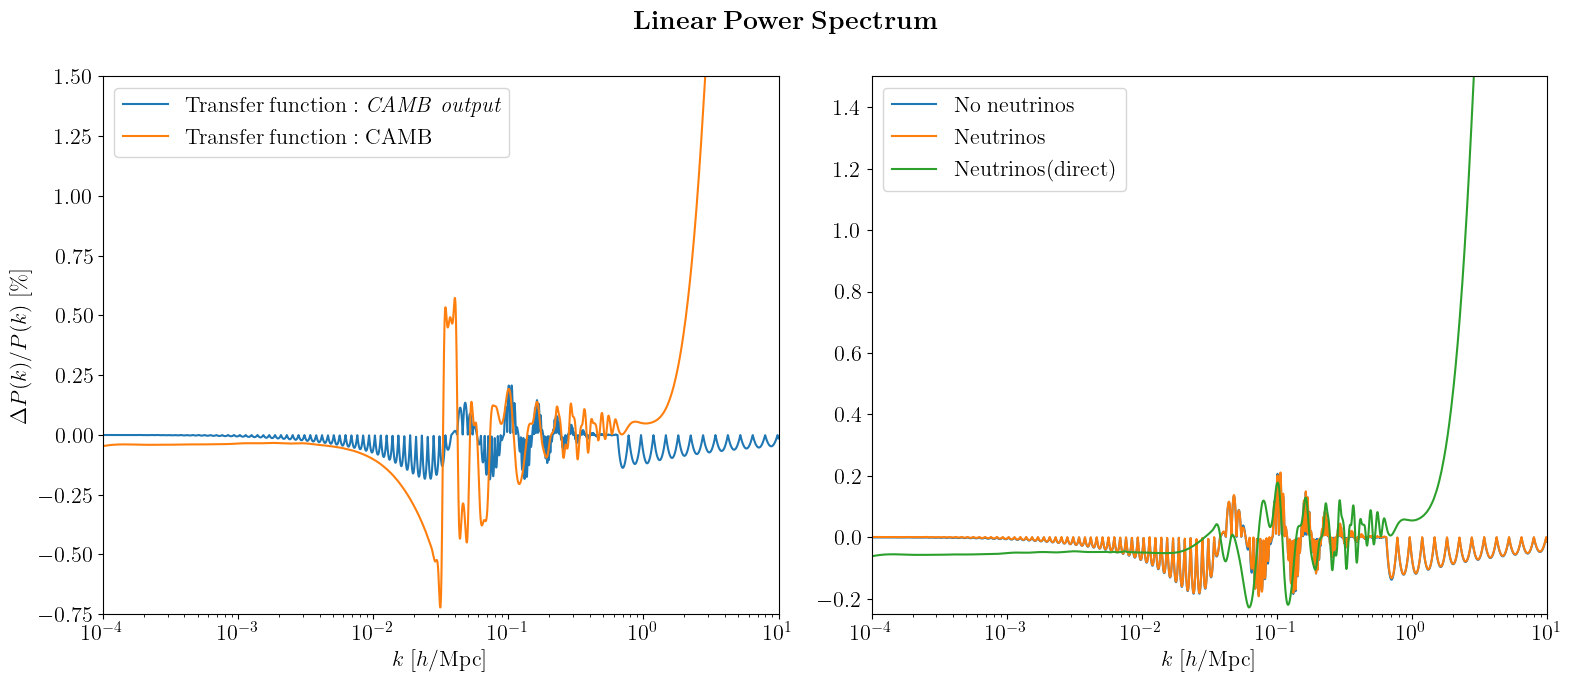

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# Transfer function check
# =================================================================================

# Transfer model = CAMB output
cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_no_neutrinos = powerspec

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot')
transfer_k = results.get_matter_transfer_data().transfer_z('k/h')

model_CAMB = Spectra(
        m_nu=0.0,
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs_pk)

# Relative Differences
diff_CAMB = (model_CAMB.power_spectrum_lin.pk_tot[0,0,:]
             - camb_pk_lin_no_neutrinos[0])/camb_pk_lin_no_neutrinos[0]
ax1.plot(kh, diff_CAMB * 100,
         label=r'$\mathrm{Transfer\ function:}$ $\mathit{CAMB\ output}$')

# =================================================================================

# Transfer model = 'CAMB'
model_NoCAMB = model_CAMB.copy()
model_NoCAMB.update(transfer_model='CAMB')

# Relative Differences
diff_noCAMB = (model_NoCAMB.power_spectrum_lin.pk_tot[0,0,:]
               - camb_pk_lin_no_neutrinos[0])/camb_pk_lin_no_neutrinos[0]
ax1.plot(kh, diff_noCAMB * 100,
         label=r'$\mathrm{Transfer\ function: CAMB}$')

# =================================================================================
# Neutrinos check
# =================================================================================

# Relative Differences - no neutrinos
diff_NoNeutrinos = (model_CAMB.power_spectrum_lin.pk_tot[0,0,:]
                    - camb_pk_lin_no_neutrinos[0])/camb_pk_lin_no_neutrinos[0]
ax2.plot(kh, diff_NoNeutrinos * 100,
         label='$\mathrm{No\ neutrinos}$')

# =================================================================================

# CAMB Power Spectrum - neutrinos
cp = camb.set_params(
    **camb_cosmo)
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_Neutrinos = powerspec

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot')
transfer_k = results.get_matter_transfer_data().transfer_z('k/h')

# =================================================================================

# Onepower Power Spectrum - neutrinos
model_CAMB_Neutrinos = Spectra(
        m_nu=0.06,
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs_pk)

# Relative Differences
diff_Neutrinos = (model_CAMB_Neutrinos.power_spectrum_lin.pk_tot[0,0,:]
                  - camb_pk_lin_Neutrinos[0])/camb_pk_lin_Neutrinos[0]
ax2.plot(kh, diff_Neutrinos * 100,
         label=r'$\mathrm{Neutrinos}$')

model_NoCAMB_Neutrinos = Spectra(
        m_nu=0.06,
        sigma_8=results.get_sigma8_0(),
        transfer_model='CAMB',
        transfer_params={},
        **params_cosmo, **params_pk, **kwargs_pk)

# Relative Differences
diff_Neutrinos = (model_NoCAMB_Neutrinos.power_spectrum_lin.pk_tot[0,0,:]
                  - camb_pk_lin_Neutrinos[0])/camb_pk_lin_Neutrinos[0]
ax2.plot(kh, diff_Neutrinos * 100,
         label=r'$\mathrm{Neutrinos (direct)}$')

ax1.legend()
ax2.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        ylim=(-0.75, 1.5),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)\ [\%]$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        ylim=(-0.25, 1.5),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$')

fig.suptitle('$\mathbf{Linear\ Power\ Spectrum}$')

plt.tight_layout()
plt.savefig('Pk_linear_comparisons.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

#
## Accuracy Settings

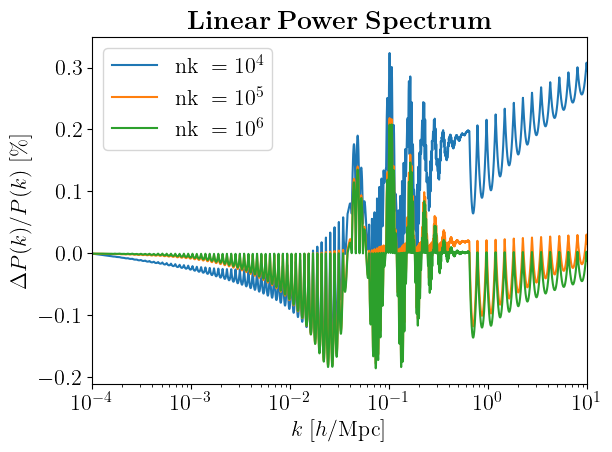

In [ ]:
# =================================================================================
# Set up

cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)
cp.set_dark_energy(**camb_de)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z('delta_tot')
transfer_k = results.get_matter_transfer_data().transfer_z('k/h')


# =================================================================================
# nk = 10 ** 4

nk = 10 ** 4

powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_accuracy = powerspec

params_accuracy = {
    'k_vec': np.logspace(-4, 0, 5000),
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': float((np.log(10**(k_upper)) - np.log(10**(k_lower))) / nk),
    'z_vec': [0.0],
}

model_accuracy = Spectra(
        sigma_8=results.get_sigma8_0(),
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_accuracy, **kwargs_pk)

diff_accuracy = (model_accuracy.power[0,:]
				 - camb_pk_lin_accuracy[0])/camb_pk_lin_accuracy[0]
plt.plot(kh, diff_accuracy * 100,
		 label=r'$\mathrm{nk\ =}\ 10^4$')

# =================================================================================
# k_points = 10 ** 5

nk = 10 ** 5

powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_accuracy = powerspec

params_accuracy = {
    'k_vec': np.logspace(-4, 0, 5000),
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': float((np.log(10**(k_upper)) - np.log(10**(k_lower))) / nk),
    'z_vec': [0.0],
}

model_accuracy = Spectra(
        sigma_8=results.get_sigma8_0(),
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_accuracy, **kwargs_pk)

diff_accuracy = (model_accuracy.power[0,:]
				 - camb_pk_lin_accuracy[0])/camb_pk_lin_accuracy[0]
plt.plot(kh, diff_accuracy * 100,
	label=r'$\mathrm{nk\ =}\ 10^5$')

# =================================================================================
# nk = 10 ** 6

nk = 10 ** 6

powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_accuracy = powerspec

params_accuracy = {
    'k_vec': np.logspace(-4, 0, 5000),
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': float((np.log(10**(k_upper)) - np.log(10**(k_lower))) / nk),
    'z_vec': [0.0],
}

model_accuracy = Spectra(
        sigma_8=results.get_sigma8_0(),
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_accuracy, **kwargs_pk)

diff_accuracy = (model_accuracy.power[0,:]
				 - camb_pk_lin_accuracy[0])/camb_pk_lin_accuracy[0]
plt.plot(kh, diff_accuracy * 100,
		 label=r'$\mathrm{nk\ =}\ 10^6$')

plt.legend()

plt.xscale('log')
plt.xlim(10.0**k_lower, 10.0**k_upper)
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\Delta P(k) / P(k)\ [\%]$')
plt.title(r'$\mathbf{Linear\ Power\ Spectrum}$')

plt.tight_layout()
plt.savefig('Pk_linear_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()